In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Charger les données (remplacez ceci par le chemin de votre fichier CSV)
immo = pd.read_csv('immo.csv')

# Calcule de l'âge de la vente (en jours) par rapport à aujourd'hui
immo['prev_sold_date'] = pd.to_datetime(immo['prev_sold_date'])
immo['age_of_sale'] = (datetime.now() - immo['prev_sold_date']).dt.days

# Sélection des colonnes pour le One-Hot Encoding et la standardisation
colonnes_numeriques = ['bed', 'bath', 'acre_lot', 'house_size','age_of_sale']
colonnes_categorielles = ['city', 'state','zip_code']

# Prétraitement avec One-Hot Encoding pour les variables catégorielles et standardisation pour les variables numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', QuantileTransformer(), colonnes_numeriques),
        ('cat', OneHotEncoder(handle_unknown='ignore'), colonnes_categorielles)
    ])

# Séparation des données en features (X) et target (y)
X = immo.drop('price', axis=1)
y = immo['price']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("prétraitement fait")

# Initialisation des paramètres
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 20)]
max_features = ['log2','sqrt']
max_depth = [10,15,20,25,30]
min_samples_split = [5,10,15,20]
min_samples_leaf = [1,3,5,7]
bootstrap = [True, False]

# Création de la grid des paramètres
param_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_split' : min_samples_split,
             'min_samples_leaf' : min_samples_leaf,
             'bootstrap' : bootstrap}

rf = RandomForestRegressor()

from sklearn.model_selection import RandomizedSearchCV
rf_grid = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, cv = 5, verbose=2, n_jobs = 6, n_iter=20)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', rf_grid)])

# Entraînement du modèle
pipeline.fit(X_train, y_train)



# À ce stade, le modèle a été entraîné. Vous pouvez évaluer sa performance sur X_test et y_test.
# Pour l'ajustement des hyperparamètres, vous pouvez utiliser GridSearchCV ou RandomizedSearchCV de scikit-learn.

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Évaluation du modèle sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calcul des métriques de performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Affichage des résultats de performance
print("Erreur quadratique moyenne (MSE) : ", mse)
print("Erreur absolue moyenne (MAE) : ", mae)
print("Coefficient de détermination (R^2) : ", r2)

prétraitement fait
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Erreur quadratique moyenne (MSE) :  633841594404.8353
Erreur absolue moyenne (MAE) :  330757.0164308548
Coefficient de détermination (R^2) :  0.554549820621054


In [7]:
import math

print("Erreur quadratique moyenne (MSE) : ", mse)
rmse = math.sqrt(mse)
print("Racine de l'erreur quadratique moyenne (RMSE) : ", rmse)
print("Erreur absolue moyenne (MAE) : ", mae)
print("Coefficient de détermination (R^2) : ", r2)

rf_grid.best_params_


Erreur quadratique moyenne (MSE) :  633841594404.8353
Racine de l'erreur quadratique moyenne (RMSE) :  796141.6924171447
Erreur absolue moyenne (MAE) :  330757.0164308548
Coefficient de détermination (R^2) :  0.554549820621054


{'n_estimators': 415,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

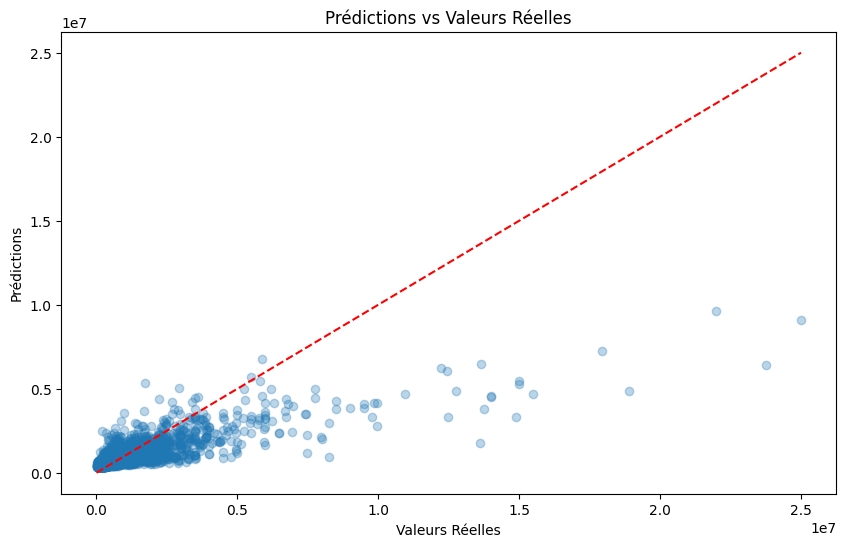

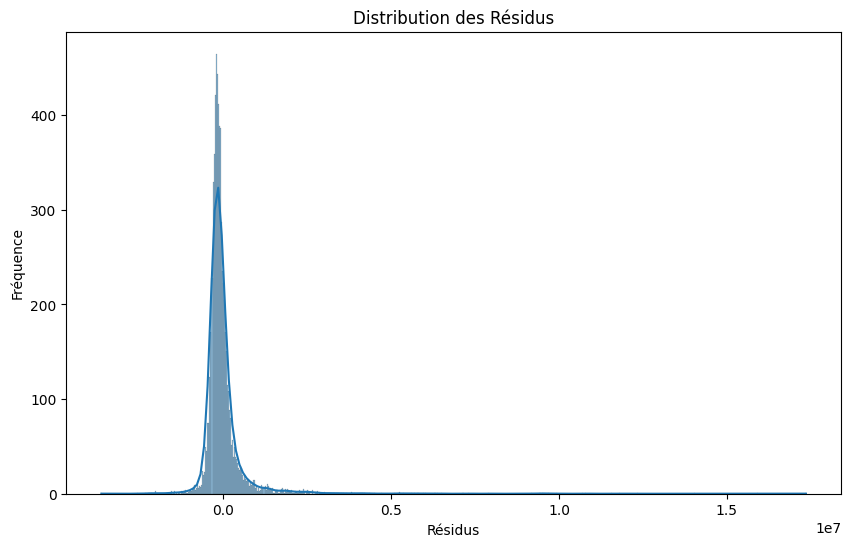

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des résidus
residus = y_test - y_pred

# Graphique de Prédiction vs Réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

# Histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residus, kde=True)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Distribution des Résidus')
plt.show()
